In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# reading data
df = pd.read_csv('./dataset/reviews.csv')
# dfcour = pd.read_csv('./dataset/reviews_by_course.csv')

In [3]:
df.head()

,CourseId,Review,Label
0,2-speed-it,BOring,1
1,2-speed-it,Bravo !,5
2,2-speed-it,Very goo,5
3,2-speed-it,"Great course - I recommend it for all, especia...",5
4,2-speed-it,One of the most useful course on IT Management!,5


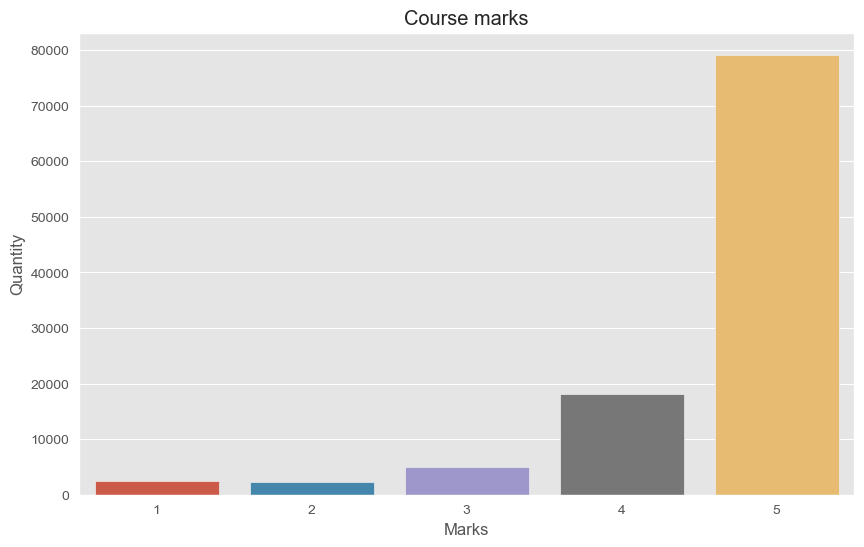

In [5]:
label_counts = df['Label'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Course marks')
plt.xlabel('Marks')
plt.ylabel('Quantity')
plt.show()

In [6]:
review = df['Review'][5]
print(review)

Great course - I recommend it for all, especially IT and Business Managers!


In [7]:
tokens = nltk.word_tokenize(review)
tokens[:10]

['Great',
 'course',
 '-',
 'I',
 'recommend',
 'it',
 'for',
 'all',
 ',',
 'especially']

In [8]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Great', 'NNP'),
 ('course', 'NN'),
 ('-', ':'),
 ('I', 'PRP'),
 ('recommend', 'VBP'),
 ('it', 'PRP'),
 ('for', 'IN'),
 ('all', 'DT'),
 (',', ','),
 ('especially', 'RB')]

In [10]:
## VADER ANALYSIS
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/andrey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
# testing 
positive = sia.polarity_scores('I love Python')
negative = sia.polarity_scores('This is the worst course ever')
print(positive)
print(negative)

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}


In [9]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  (GPE Great/NNP)
  course/NN
  -/:
  I/PRP
  recommend/VBP
  it/PRP
  for/IN
  all/DT
  ,/,
  especially/RB
  IT/NNP
  and/CC
  (ORGANIZATION Business/NNP Managers/NNPS)
  !/.)


In [12]:
sia.polarity_scores(review)

{'neg': 0.0, 'neu': 0.566, 'pos': 0.434, 'compound': 0.784}

In [13]:
# run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
        text = row['Review']
        myid = row['Id']
        res[myid] = sia.polarity_scores(text)
print(res)

  0%|          | 0/107018 [00:00<?, ?it/s]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [16]:
# now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,Review,Label
0,0,0.0,0.152,0.848,0.6808,good and interesting,5
1,1,0.0,0.866,0.134,0.4754,"This class is very helpful to me. Currently, I...",5
2,2,0.0,0.575,0.425,0.8843,like!Prof and TAs are helpful and the discussi...,5
3,3,0.0,0.701,0.299,0.5719,Easy to follow and includes a lot basic and im...,5
4,4,0.0,0.794,0.206,0.3266,Really nice teacher!I could got the point eazl...,4


Text(0.5, 1.0, 'Compound Score by Coursera`s Course')

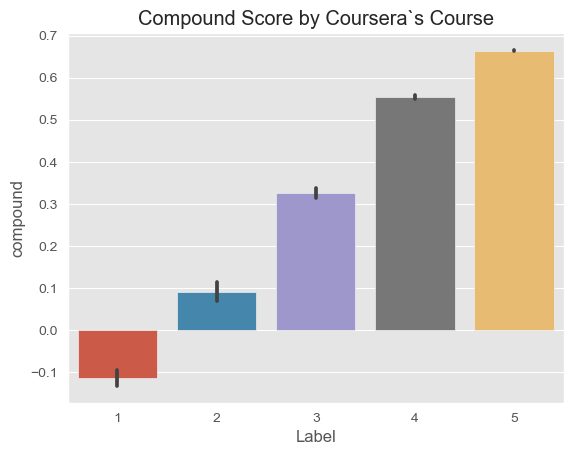

In [17]:
ax = sns.barplot(data=vaders, x='Label', y='compound')
ax.set_title('Compound Score by Coursera`s Course')

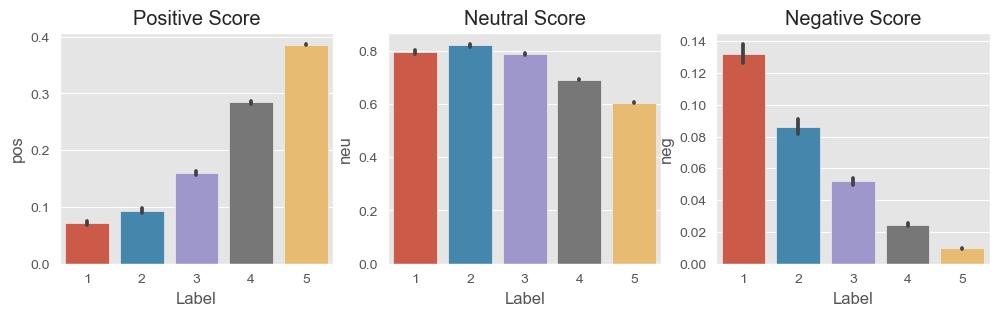

In [18]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
sns.barplot(data=vaders, x='Label', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Label', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Label', y='neg', ax=axs[2])
axs[0].set_title('Positive Score')
axs[1].set_title('Neutral Score')
axs[2].set_title('Negative Score')
plt.show()

In [19]:
#Roberta Pretrained Model
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [20]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [21]:
# VADER res on review
print(review)
sia.polarity_scores(review)

Great course - I recommend it for all, especially IT and Business Managers!


{'neg': 0.0, 'neu': 0.566, 'pos': 0.434, 'compound': 0.784}

In [22]:
#Run for Roberta Model 
encoded_text = tokenizer(review, return_tensors='pt')
output = model(**encoded_text)
# print(output)
labels = output[0][0].detach().numpy()
labels = softmax(labels)
scores_dict = {
    'roberta_neg': labels[0],
    'roberta_neu': labels[1],
    'roberta_pos': labels[2]
}
print(scores_dict)

{'roberta_neg': 0.0016169129, 'roberta_neu': 0.021036461, 'roberta_pos': 0.9773466}


In [25]:
def polarity_scores_roberta(review_input):
    #Run for Roberta Model 
    encoded_text = tokenizer(review_input, return_tensors='pt')
    output = model(**encoded_text)
    # print(output)
    labels = output[0][0].detach().numpy()
    labels = softmax(labels)
    scores_dict = {
        'roberta_neg': labels[0],
        'roberta_neu': labels[1],
        'roberta_pos': labels[2]
    }
    print(scores_dict)
    return scores_dict

In [26]:
# run the polarity score on the entire dataset
partial_dataframe = df[:500]
res = {}
for i, row in tqdm(partial_dataframe.iterrows(), total=len(partial_dataframe)):
    try:
        text = row['Review']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f"Broke for id {myid}")
        

  0%|          | 0/500 [00:00<?, ?it/s]

{'roberta_neg': 0.0049254913, 'roberta_neu': 0.06450213, 'roberta_pos': 0.93057245}
{'roberta_neg': 0.0017417651, 'roberta_neu': 0.025957484, 'roberta_pos': 0.9723007}
{'roberta_neg': 0.0012802425, 'roberta_neu': 0.013505926, 'roberta_pos': 0.9852138}
{'roberta_neg': 0.0028339867, 'roberta_neu': 0.08094344, 'roberta_pos': 0.91622263}
{'roberta_neg': 0.006642156, 'roberta_neu': 0.06928422, 'roberta_pos': 0.9240736}
{'roberta_neg': 0.0016169129, 'roberta_neu': 0.021036461, 'roberta_pos': 0.9773466}
{'roberta_neg': 0.0013154624, 'roberta_neu': 0.023298621, 'roberta_pos': 0.97538596}
{'roberta_neg': 0.49969095, 'roberta_neu': 0.37324435, 'roberta_pos': 0.12706469}
{'roberta_neg': 0.0013620027, 'roberta_neu': 0.021017728, 'roberta_pos': 0.9776203}
{'roberta_neg': 0.0013501131, 'roberta_neu': 0.02950001, 'roberta_pos': 0.96914995}
{'roberta_neg': 0.02176074, 'roberta_neu': 0.24176675, 'roberta_pos': 0.73647255}
{'roberta_neg': 0.0020857307, 'roberta_neu': 0.01342344, 'roberta_pos': 0.9844908